<a href="https://colab.research.google.com/github/MKrezheska/data-mining-project/blob/main/3_lda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LDA

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn import datasets, linear_model
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import seaborn as sns
from sklearn import tree
from sklearn.metrics import accuracy_score
%matplotlib inline
from sklearn.tree import DecisionTreeClassifier, export_graphviz

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/My Drive/with_genres.csv")
df.head(1)

,Unnamed: 0,Unnamed: 0.1,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,popularity,uri,title,artist,year,target,genre
0,0,0,0.425,0.1,135.128,0.375,0.328,0.13,4,0.701,7,194088,-10.965,0.562,1,audio_features,89,spotify:track:2Fxmhks0bxGSBdJ92vM42m,bad guy,Billie Eilish,2019,1,22


In [5]:
df = df.drop(["Unnamed: 0","Unnamed: 0.1"], axis="columns")
df.head(100)

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,type,popularity,uri,title,artist,year,target,genre
0,0.425,0.1000,135.128,0.3750,0.328000,0.130000,4,0.701,7,194088,-10.965,0.5620,1,audio_features,89,spotify:track:2Fxmhks0bxGSBdJ92vM42m,bad guy,Billie Eilish,2019,1,22
1,0.125,0.2650,111.554,0.2390,0.751000,0.002070,4,0.521,9,243725,-17.832,0.0528,1,audio_features,78,spotify:track:4QIo4oxwzzafcBWkKjDpXY,xanny,Billie Eilish,2019,1,22
2,0.533,0.1390,150.455,0.1860,0.462000,0.219000,4,0.678,4,180953,-10.485,0.3230,1,audio_features,81,spotify:track:3XF5xLJHOQQRbWya6hBp7d,you should see me in a crown,Billie Eilish,2019,1,22
3,0.444,0.1770,185.044,0.3720,0.283000,0.143000,4,0.726,8,168840,-8.922,0.5690,0,audio_features,80,spotify:track:6IRdLKIyS4p7XNiP8r6rsx,all the good girls go to hell,Billie Eilish,2019,1,22
4,0.351,0.7520,118.028,0.2410,0.390000,0.000009,4,0.853,7,221543,-10.198,0.2820,1,audio_features,81,spotify:track:3Fj47GNK2kUF0uaEDgXLaD,wish you were gay,Billie Eilish,2019,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.836,0.0550,132.937,0.0438,0.000143,0.000507,4,0.484,1,494773,-4.658,0.4030,1,audio_features,41,spotify:track:5jE2hljNVTJZeodUXQu9Ea,Fixxxer,Metallica,1997,1,26
96,0.903,0.0979,157.825,0.0314,0.000022,0.052200,4,0.426,10,304400,-4.535,0.4420,0,audio_features,48,spotify:track:3QWzxUE2WA5WoSi82KCODk,Ain't My Bitch,Metallica,1996,1,26
97,0.907,0.5490,115.217,0.0345,0.000005,0.008570,4,0.512,1,328200,-4.432,0.6730,0,audio_features,45,spotify:track:0SwHR5lvAfgI8Z2D6YgvMd,2 X 4,Metallica,1996,1,26
98,0.859,0.1550,94.437,0.0307,0.000018,0.003410,4,0.478,4,398867,-5.347,0.2860,1,audio_features,45,spotify:track:2UmXstEJ8nkpUUfQRYieC6,The House That Jack Built,Metallica,1996,1,26


In [6]:
df.drop(['title','artist', 'uri', 'type'], axis=1, inplace=True)
df.head(1991)

,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,popularity,year,target,genre
0,0.425,0.100,135.128,0.3750,0.32800,0.130000,4,0.701,7,194088,-10.965,0.5620,1,89,2019,1,22
1,0.125,0.265,111.554,0.2390,0.75100,0.002070,4,0.521,9,243725,-17.832,0.0528,1,78,2019,1,22
2,0.533,0.139,150.455,0.1860,0.46200,0.219000,4,0.678,4,180953,-10.485,0.3230,1,81,2019,1,22
3,0.444,0.177,185.044,0.3720,0.28300,0.143000,4,0.726,8,168840,-8.922,0.5690,0,80,2019,1,22
4,0.351,0.752,118.028,0.2410,0.39000,0.000009,4,0.853,7,221543,-10.198,0.2820,1,81,2019,1,22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986,0.364,0.101,123.022,0.0287,0.54500,0.000069,4,0.340,9,203760,-8.331,0.1100,1,41,2019,0,16
1987,0.886,0.096,126.044,0.0443,0.00114,0.000014,4,0.490,8,213333,-5.404,0.4930,1,45,2019,0,16
1988,0.475,0.104,101.069,0.0265,0.34800,0.000025,4,0.475,2,275133,-7.319,0.1290,1,40,2019,0,16
1989,0.637,0.100,76.037,0.0313,0.24900,0.000006,4,0.568,7,192107,-5.977,0.4520,1,39,2019,0,16


In [7]:
cols = ['genre']  + [col for col in df if col != 'genre']
df = df[cols]

In [8]:
df.head(100)

,genre,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,popularity,year,target
0,22,0.425,0.1000,135.128,0.3750,0.328000,0.130000,4,0.701,7,194088,-10.965,0.5620,1,89,2019,1
1,22,0.125,0.2650,111.554,0.2390,0.751000,0.002070,4,0.521,9,243725,-17.832,0.0528,1,78,2019,1
2,22,0.533,0.1390,150.455,0.1860,0.462000,0.219000,4,0.678,4,180953,-10.485,0.3230,1,81,2019,1
3,22,0.444,0.1770,185.044,0.3720,0.283000,0.143000,4,0.726,8,168840,-8.922,0.5690,0,80,2019,1
4,22,0.351,0.7520,118.028,0.2410,0.390000,0.000009,4,0.853,7,221543,-10.198,0.2820,1,81,2019,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,26,0.836,0.0550,132.937,0.0438,0.000143,0.000507,4,0.484,1,494773,-4.658,0.4030,1,41,1997,1
96,26,0.903,0.0979,157.825,0.0314,0.000022,0.052200,4,0.426,10,304400,-4.535,0.4420,0,48,1996,1
97,26,0.907,0.5490,115.217,0.0345,0.000005,0.008570,4,0.512,1,328200,-4.432,0.6730,0,45,1996,1
98,26,0.859,0.1550,94.437,0.0307,0.000018,0.003410,4,0.478,4,398867,-5.347,0.2860,1,45,1996,1


In [9]:
from sklearn.utils import shuffle
df = shuffle(df)
df.head(1991)

,genre,energy,liveness,tempo,speechiness,acousticness,instrumentalness,time_signature,danceability,key,duration_ms,loudness,valence,mode,popularity,year,target
1736,19,0.709,0.0967,153.776,0.2530,0.45800,0.000000,4,0.698,7,187640,-5.055,0.859,1,34,2020,0
1240,12,0.718,0.1420,140.019,0.0406,0.60000,0.000000,4,0.421,9,291202,-5.332,0.381,0,20,2017,0
1415,19,0.519,0.1590,135.871,0.0576,0.31700,0.000000,4,0.700,0,187822,-7.091,0.650,1,67,2020,0
1160,34,0.867,0.3290,92.964,0.0437,0.00425,0.000000,4,0.352,5,226373,-6.777,0.954,0,15,2014,0
1172,34,0.687,0.2780,94.731,0.1490,0.12000,0.000004,4,0.737,10,176747,-8.029,0.913,1,6,2020,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,22,0.573,0.4820,99.939,0.1060,0.46000,0.073400,4,0.695,4,179172,-8.597,0.408,0,77,2017,1
1711,19,0.598,0.1370,76.047,0.0283,0.22900,0.000009,4,0.655,7,221627,-5.241,0.549,1,37,1999,0
1149,34,0.735,0.0981,163.981,0.2210,0.24400,0.000000,4,0.687,2,187280,-6.430,0.630,0,5,2006,0
253,5,0.655,0.3640,99.982,0.0542,0.60400,0.001930,4,0.504,0,264066,-8.644,0.262,0,69,2017,1


Делење на податочното множество на тренирачко, валидациско и тестирачко множество, 
    така што првите 70% од секоја од класите  се доделени во тренирачкото множество. 
    Следните 10% од секоја од класите влегуваат во валидациско множество, 
    а последните 20% од секоја од класите се дел од тестирачкото множество.
    На крај се прави shuffle на множествата (заедно со соодветните лабели).

In [ ]:
tmp = df.values.tolist()
dataset =  [[row[i] if i != len(row)-1 else int(row[i]) for i in range(len(row))] for row in tmp]
print(tmp)
print(dataset)

bad_classes = [x for x in dataset if x[-1] == 0]
good_classes = [x for x in dataset if x[-1] == 1]

train_set =  bad_classes[:int(len(bad_classes) * 0.7)] + good_classes[:int(len(good_classes) * 0.7)]
val_set = bad_classes[int(len(bad_classes) * 0.7):int(len(bad_classes) * 0.8)] + good_classes[int(len(good_classes) * 0.7):int(len(good_classes) * 0.8)]
test_set =  bad_classes[int(len(bad_classes) * 0.8):] + good_classes[int(len(good_classes) * 0.8):]

train_x = [x[:-1] for x in train_set]
train_y = [x[-1] for x in train_set]
val_x = [x[:-1] for x in val_set]
val_y = [x[-1] for x in val_set]
test_x = [x[:-1] for x in test_set]
test_y = [x[-1] for x in test_set]


In [11]:
import collections
X_train = np.array(train_x)
y_train = np.array(train_y)
X_val = np.array(val_x)
y_val = np.array(val_y)
X_test = np.array(test_x)
y_test = np.array(test_y)

from sklearn.utils import shuffle
X_train,y_train = shuffle(X_train,y_train,random_state=0)
X_val, y_val = shuffle(X_val, y_val,random_state=0)
X_test, y_test = shuffle(X_test, y_test,random_state=0)

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(collections.Counter(y_train))
print(collections.Counter(y_val))
print(collections.Counter(y_test))

(1392, 16) (200, 16) (399, 16)
(1392,) (200,) (399,)
Counter({1: 702, 0: 690})
Counter({1: 101, 0: 99})
Counter({1: 201, 0: 198})


In [12]:
X_train.shape

(1392, 16)

In [31]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# prepare dataset
data = X_train
y = y_train
# define transform
lda = LinearDiscriminantAnalysis()
# prepare transform on dataset
lda.fit(data, y)
# apply transform to dataset
transformed = lda.transform(data)

In [32]:
X_train = transformed

In [16]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# prepare dataset
data = X_val
y = y_val
# define transform
lda = LinearDiscriminantAnalysis()
# prepare transform on dataset
lda.fit(data, y)
# apply transform to dataset
transformed = lda.transform(data)
X_val = transformed

In [17]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# prepare dataset
data = X_test
y = y_test
# define transform
lda = LinearDiscriminantAnalysis()
# prepare transform on dataset
lda.fit(data, y)
# apply transform to dataset
transformed = lda.transform(data)
X_test = transformed

In [18]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [19]:
xtrain = np.concatenate((X_train,X_val)) 
ytrain = np.concatenate((y_train,y_val))  

Освен за намалување на димензионалноста LDA се користи и за кластерирање.

              precision    recall  f1-score   support

           0       0.75      0.82      0.78       198
           1       0.80      0.74      0.77       201

    accuracy                           0.78       399
   macro avg       0.78      0.78      0.78       399
weighted avg       0.78      0.78      0.78       399



[]

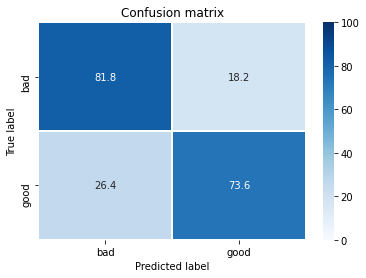

In [35]:
from sklearn.metrics import classification_report

pred = lda.predict(X_test)
print(classification_report(y_test, pred))
# Визуелизација со матрица на конфузија
cm=confusion_matrix(y_test,pred)
names = ['bad', 'good'] 

cm = 100 * cm.astype('float') / cm.sum(axis=-1)[:, np.newaxis]  

import seaborn as sn
from sklearn.metrics import confusion_matrix
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
df = pd.DataFrame(data=cm, columns=names, index=names)
g = sn.heatmap(df, annot=True, fmt=".1f", linewidths=.5, vmin=0, vmax=100,
                    cmap='Blues')
g.set_title('Confusion matrix')
g.set_ylabel('True label')
g.set_xlabel('Predicted label')
g.plot()

Проба на некои од моделите со користење на податочното множество со редуцирана димензионалност со помош на LDA.

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

dtc = DecisionTreeClassifier()
nbc = GaussianNB()
rfc = RandomForestClassifier()

dtc.fit(xtrain, ytrain)
nbc.fit(xtrain, ytrain)
rfc.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [21]:
importances = list(rfc.feature_importances_)
indices = np.argsort(importances)[::-1]

most_important_feature = importances.index(max(importances))
least_important_feature = importances.index(min(importances))
print('Most important feature: '+ df.columns[most_important_feature])
print('Least important feature: '+ df.columns[least_important_feature])

Most important feature: genre
Least important feature: genre


In [22]:
from sklearn.metrics import classification_report

tree_predict = dtc.predict(X_val)
naive_predict = nbc.predict(X_val)
random_forest_predict = rfc.predict(X_val)

print('Decision Tree score on validation:\n', classification_report( y_val,tree_predict))
print('Naive Bayes score on validation:\n', classification_report( y_val,naive_predict))
print('Random Forest score on validation:\n', classification_report( y_val,random_forest_predict))

Decision Tree score on validation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00       101

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200

Naive Bayes score on validation:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81        99
           1       0.86      0.72      0.78       101

    accuracy                           0.80       200
   macro avg       0.81      0.80      0.80       200
weighted avg       0.81      0.80      0.80       200

Random Forest score on validation:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        99
           1       1.00      1.00      1.00       101

    accuracy                           1.00       200
   macro avg       1.0

In [23]:
from sklearn.metrics import classification_report

test_tree_predict = dtc.predict(X_test)
test_naive_predict = nbc.predict(X_test)
test_random_forest_predict = rfc.predict(X_test)

print('Decision Tree score on test:\n', classification_report( y_test,test_tree_predict))
print('Naive Bayes score on test:\n', classification_report( y_test,test_naive_predict))
print('Random Forest score on test:\n', classification_report( y_test,test_random_forest_predict))

Decision Tree score on test:
               precision    recall  f1-score   support

           0       0.71      0.71      0.71       198
           1       0.71      0.72      0.72       201

    accuracy                           0.71       399
   macro avg       0.71      0.71      0.71       399
weighted avg       0.71      0.71      0.71       399

Naive Bayes score on test:
               precision    recall  f1-score   support

           0       0.73      0.85      0.79       198
           1       0.83      0.70      0.76       201

    accuracy                           0.77       399
   macro avg       0.78      0.78      0.77       399
weighted avg       0.78      0.77      0.77       399

Random Forest score on test:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71       198
           1       0.72      0.72      0.72       201

    accuracy                           0.72       399
   macro avg       0.72      0.72      0

In [24]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, test_random_forest_predict)

0.7167571234735415

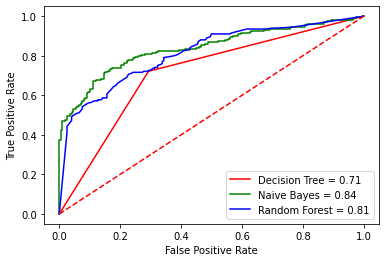

In [25]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

actual = y_test
decision_tree_prob = [p[1] for p in dtc.predict_proba(X_test)]
naive_bayes_prob = [p[1] for p in nbc.predict_proba(X_test)]
random_forest_prob = [p[1] for p in rfc.predict_proba(X_test)]

dt_false_pos, dt_true_pos, _ = roc_curve(actual, decision_tree_prob)
dt_auc = auc(dt_false_pos, dt_true_pos)

nb_false_pos, nb_true_pos, _ = roc_curve(actual, naive_bayes_prob)
nb_auc = auc(nb_false_pos, nb_true_pos)

rf_false_pos, rf_true_pos, _ = roc_curve(actual, random_forest_prob)
rf_auc = auc(rf_false_pos, rf_true_pos)

# plot
plt.plot(dt_false_pos, dt_true_pos, 'r', label='Decision Tree = %0.2f'% dt_auc)
plt.plot(nb_false_pos, nb_true_pos, 'g', label='Naive Bayes = %0.2f'% nb_auc)
plt.plot(rf_false_pos, rf_true_pos, 'b', label='Random Forest = %0.2f'% rf_auc)

plt.legend(loc='lower right')
plt.plot([0,1], [0,1], 'r--')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()